# Data import 


In [1]:
import pandas as pd
# import of data
student_data_unpr = pd.read_excel("../data/subset_studium_german.xlsx")
student_data_unpr = student_data_unpr.drop("Unnamed: 0", axis=1)
student_data_unpr = student_data_unpr.drop("Studium_Comment", axis=1)

#Reduction to 300 entries
student_data_unpr = student_data_unpr.drop(student_data_unpr.index[300:], axis=0)

#Creation of a copy and reduction to column "Studium"
student_data = student_data_unpr
student_data = student_data.drop("Studium_Label", axis=1)


# OpenAI GPT3.5 application

In [2]:
from openai import OpenAI
client = OpenAI()

In [3]:
#Prompt for GPT
initial_message = {"role": "user", "content": "You are my sentiment assistant. I want you to analyze my text and categorize it into the three sentiments: positive, neutral, negative. Only response with either positive, neutral or negative."}

results=[]
results_df = []

# Sending labeling requests to GPT
for index, eintrag in student_data.iterrows():
    for inhalt in eintrag:
        response = client.chat.completions.create(
        model="gpt-3.5-turbo",
            messages=[
                initial_message,
                {"role": "user", "content": inhalt}
            ],
            temperature=0,
            seed = 123
        )
        
        # Saving of responses 
        results.append({"index": index, "sentimentPrediction": response.choices[0].message.content.lower()})

# Conversion of responses into dataframe
results_df = pd.DataFrame(results)




In [4]:
display(results_df.head(20))
display(student_data)

,index,sentimentPrediction
0,0,neutral
1,1,positive
2,2,neutral
3,3,positive
4,4,neutral
5,5,positive
6,6,positive
7,7,positive
8,8,positive
9,9,negative


,Studium
0,Die Vorlesungszeit war von Anfang September bi...
1,Die Pazmany Universität ist sehr klein im Verg...
2,Mit der Universität selbst hatten wir wenig zu...
3,Da die Vorlesungen wegen der Pandemie online s...
4,Die City University of Hong Kong hat eine groß...
...,...
295,Meiner Meinung nach ist das Studium in Exeter ...
296,Das Studium an der Eötvös-Lórand University un...
297,Die Universitat de Barcelona ist eine wundersc...
298,Die Cardiff University sieht sich selbst als r...


# Evaluation

In [5]:
#Merge target labels with predicted labels
results_df = results_df.drop("index", axis=1)


student_data = pd.concat([student_data_unpr, results_df], axis=1)
student_data = student_data[student_data["Studium_Label"].notnull()]


#Convertion of all values into strings
for x in student_data:
    student_data[x] = student_data[x].astype(str)


In [5]:
#Merge target labels with predicted labels
results_df = results_df.drop("index", axis=1)


student_data = pd.concat([student_data_unpr, results_df], axis=1)
student_data = student_data[student_data["Studium_Label"].notnull()]


#Convertion of all values into strings
for x in student_data:
    student_data[x] = student_data[x].astype(str)


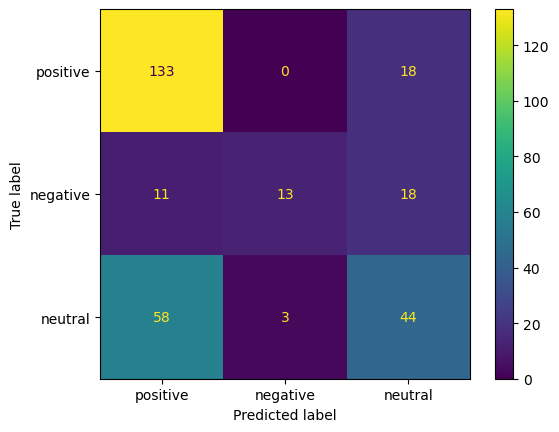

0.6375838926174496
              precision    recall  f1-score   support

    positive       0.81      0.31      0.45        42
    negative       0.55      0.42      0.48       105
     neutral       0.66      0.88      0.75       151

    accuracy                           0.64       298
   macro avg       0.67      0.54      0.56       298
weighted avg       0.64      0.64      0.61       298



In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
import matplotlib.pyplot as plt

#Creation of confusion matrix
confusion_mat = confusion_matrix(student_data['Studium_Label'], student_data['sentimentPrediction'], labels=['positive', 'negative', 'neutral'])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['positive', 'negative', 'neutral'])
disp.plot()
plt.show()

#Accuracy
print(f1_score(student_data['Studium_Label'], student_data['sentimentPrediction'], labels=['positive', 'negative', 'neutral'], average='micro'))

#Creation of presicion, recall, F1 and support
print(classification_report(
    student_data['Studium_Label'],
    student_data['sentimentPrediction'],
    output_dict=False,
    target_names=['positive', 'negative', 'neutral']
))

# Alteration of prompt towards more negative categorization

In [3]:
#Prompt for GPT
initial_message = {"role": "user", "content": "You are my sentiment assistant. I want you to analyze my text and categorize it into the three sentiments: positive, neutral, negative. However, if a text has negative aspects, have a higher tendency towards a negative rating. Only response with either positive, neutral or negative."}

results=[]
results_df = []

# Sending labeling requests to GPT
for index, eintrag in student_data.iterrows():
    for inhalt in eintrag:
        response = client.chat.completions.create(
        model="gpt-3.5-turbo",
            messages=[
                initial_message,
                {"role": "user", "content": inhalt}
            ],
            temperature=0,
            seed = 123
        )
        
        # Saving of responses 
        results.append({"index": index, "sentimentPrediction": response.choices[0].message.content.lower()})

# Conversion of responses into dataframe
results_df = pd.DataFrame(results)




# Evaluation 

In [5]:
#Merge target labels with predicted labels
results_df = results_df.drop("index", axis=1)


student_data = pd.concat([student_data_unpr, results_df], axis=1)
student_data = student_data[student_data["Studium_Label"].notnull()]


#Convertion of all values into strings
for x in student_data:
    student_data[x] = student_data[x].astype(str)


In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
import matplotlib.pyplot as plt

#Creation of confusion matrix
confusion_mat = confusion_matrix(student_data['Studium_Label'], student_data['sentimentPrediction'], labels=['positive', 'negative', 'neutral'])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['positive', 'negative', 'neutral'])
disp.plot()
plt.show()

#Accuracy
print(f1_score(student_data['Studium_Label'], student_data['sentimentPrediction'], labels=['positive', 'negative', 'neutral'], average='micro'))

#Creation of presicion, recall, F1 and support
print(classification_report(
    student_data['Studium_Label'],
    student_data['sentimentPrediction'],
    output_dict=False,
    target_names=['positive', 'negative', 'neutral']
))